Read head mask weights

In [1]:
import os
import safetensors.torch

weight_dict = {}
for root, dir, files in os.walk("./output/llama/xnli"):
    for file in files:
        if file.endswith(".safetensors") and "-6190" in root:
            langs = os.path.basename(os.path.dirname(root))
            path = os.path.join(root, file)
            weight_dict[langs] = safetensors.torch.load_file(path)["tensor"]
for root, dir, files in os.walk("./output/llama/fv"):
    for file in files:
        if file.endswith(".safetensors") and "-6250" in root:
            langs = os.path.basename(os.path.dirname(root))
            path = os.path.join(root, file)
            weight_dict[langs] = safetensors.torch.load_file(path)["tensor"]
print("Total tasks:", len(weight_dict))
print("Task name", "\t", "Weight", "\t", "# of up heads")
for k, v in sorted(weight_dict.items()):
    print(k, "\t", v, "\t", (v.sigmoid() >= 0.5).sum().item())

Total tasks: 77
Task name 	 Weight 	 # of up heads
adjective_v_verb_3 	 tensor([6.4547, 0.8442, 4.9701,  ..., 6.9430, 5.0350, 3.9923]) 	 845
ag_news 	 tensor([ 5.5666,  2.8047,  6.6516,  ...,  9.0351,  3.7080, -5.0000]) 	 737
antonym 	 tensor([ 4.6659,  4.4967,  4.5627,  ...,  7.9400,  3.3671, -5.0000]) 	 834
ar_de 	 tensor([ 2.9615,  4.1869,  6.5225,  ...,  2.4945, -1.8325, -5.0000]) 	 909
ar_en 	 tensor([ 1.6072,  4.0265,  5.6036,  ...,  3.5994, -1.8419, -5.0000]) 	 943
ar_es 	 tensor([ 2.2431,  3.9534,  6.6193,  ..., -1.2175,  1.0918, -5.0000]) 	 899
ar_fr 	 tensor([ 2.7471,  4.2052,  6.1395,  ..., -0.8100, -1.7978, -5.0000]) 	 908
ar_ru 	 tensor([ 2.9796,  6.1852,  5.8957,  ...,  0.2309, -1.8855, -5.0000]) 	 888
ar_zh 	 tensor([ 3.4705,  5.7370,  4.7838,  ...,  8.4880, -1.8275, -5.0000]) 	 885
capitalize 	 tensor([ 5.4693,  3.4210,  4.0721,  ...,  7.2168,  3.9582, -5.0000]) 	 895
capitalize_first_letter 	 tensor([ 4.6625,  4.4380,  2.9572,  ..., -1.6999,  4.1964, -5.0000]) 	 774
ca

Load model

In [ ]:
from transformers import AutoTokenizer
from models.modeling_llama import LlamaForCausalLM
from models.modeling_qwen2 import Qwen2ForCausalLM
from models.modeling_phi3 import Phi3ForCausalLM
from models.modeling_mistral import MistralForCausalLM
import torch
from torch import nn
DEVICE = "cuda:0"

MODEL_DIR = "/public/share/model/Meta-Llama-3.1-8B-Instruct"    # Your model path
model_name = os.path.basename(MODEL_DIR).lower()
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
model = LlamaForCausalLM.from_pretrained(       # Change "xxxForCausalLM" to your model type
    MODEL_DIR, 
    local_files_only=True, 
    device_map=DEVICE, 
    torch_dtype=torch.bfloat16,
    attn_implementation="eager",
    max_position_embeddings=2048
)
model.generation_config.pad_token_id = tokenizer.pad_token_id
n_layers = model.config.num_hidden_layers
n_heads = model.config.num_attention_heads

## Evaluate: function_vectors

In [3]:
TASK_DICT = {
    "lowercase_first_letter": "Output the first letter of the given word in lowercase.",
    "park-country": "Identify the country where the given national park is located.",
    "synonym": "Identify a synonym for the given word.",
    "ag_news": "Classify the given news headline into one of the categories: Business, Science, Sports, or World. Provide only the category name.",
    "word_length": "Determine the number of letters in the given word and output the count.",
    "present-past": "Convert the given verb from its present tense to its simple past tense.",
    "capitalize": "Output the given word with its first letter capitalized.",
    "landmark-country": "Identify the country where the given landmark is located.",
    "english-german": "Translate the given English word into German.",
    "sentiment": "Determine the sentiment of the given input. Output either 'positive' or 'negative'.",
    "country-capital": "What is the capital of the given country? Provide only the name of the capital.",
    "person-occupation": "Identify the occupation of the given individual.",
    "country-currency": "What is the official currency of the given country?",
    "lowercase_last_letter": "Output the last letter of the given word in lowercase.",
    "person-sport": "Identify the sport associated with the given individual.",
    "person-instrument": "Identify the musical instrument played by the given musician.",
    "antonym": "Identify the antonym of the given word.",
    "capitalize_last_letter": "Output the last letter of the given word in uppercase.",
    "english-french": "Translate the given English word into French.",
    "next_item": "What is the next sequential item following the given input?",
    "singular-plural": "Provide the plural form of the given singular noun.",
    "capitalize_second_letter": "Output the second letter of the given word in uppercase.",
    "prev_item": "What is the item that comes before the given input in a sequential context?",
    "capitalize_first_letter": "Output the first letter of the given word in uppercase.",
    "english-spanish": "Translate the given English word into Spanish.",
    "next_capital_letter": "What is the next uppercase letter in alphabetical order after the given input?",
    "national_parks": "Identify the U.S. state where the given national park is located.",
    "product-company": "Identify the company associated with the given product.",
    "conll2003_organization": "Extract the organization mentioned in the given text.",
    "conll2003_person": "Extract the name of the person mentioned in the given text.",
    "conll2003_location": "Extract the location mentioned in the given text.",
    "adjective_v_verb_3": "From the given words, identify the one that is an adjective.",
    "object_v_concept_3": "From the given words, identify the one that is a object.",
    "verb_v_adjective_3": "From the given words, identify the one that is a verb.",
    "fruit_v_animal_3": "From the given words, identify the one that is a fruit."
}

Evaluate FV with instructions or masks. Modify the build/run lines to your settings

In [5]:
import datasets
import pandas as pd
import copy
import numpy as np
import itertools
from tqdm.notebook import tqdm

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "<|begin_of_text|>{src}\n\n"
QWEN2_TEMPLATE = "<|im_start|>user\n{src}<|im_end|>\n<|im_start|>assistant\n"
QWEN2_PLM_TEMPLATE = "{src}\n\n"

if "llama" in model_name:
    if "instruct" in model_name:
        template = LLAMA_TEMPLATE
        print("using LLAMA_TEMPLATE")
    else:
        template = LLAMA_PLM_TEMPLATE
        print("using LLAMA_PLM_TEMPLATE")
elif "qwen2" in model_name:
    if "instruct" in model_name:
        template = QWEN2_TEMPLATE
        print("using QWEN2_TEMPLATE")
    else:
        template = QWEN2_PLM_TEMPLATE
        print("using QWEN2_PLM_TEMPLATE")
else:
    print("Unknown model")

# Build evaluation dataset
dev_datasets = []
for root, dirs, files in os.walk("./dataset/function_vectors/abstractive"):
    for file in files:
        if file.endswith(".json"):
            task = os.path.basename(file).split(".")[0]
            data_path = os.path.join(root, file)
            dataset = datasets.Dataset.from_json(data_path)
            dataset = dataset.map(
                lambda sample: {
                    # Case w/ instruction: use this line
                    "input_str": TASK_DICT[task] + f"\n\nInput:\n\n{sample['input']}\n\nOutput:\n\n",
                    # Case w/o instruction: use this line
                    # "input_str": sample["input"],
                    "target_str": sample["output"],
                }
            )

            dataset = dataset.remove_columns(["input", "output"])
            dev_dataset = dataset.select(range(len(dataset) - 100, len(dataset)))
            dev_datasets.append((task, dev_dataset))
# Run evaluation
for task, dataset in tqdm(dev_datasets):
    mask_weight = (weight_dict[task].sigmoid() >= 0.5).float().numpy()
    mask_tensor = torch.tensor(mask_weight).unsqueeze(0).repeat(1, 1).to(model.device)

    correct = 0
    for sample in dataset:
        input_str, target_str = str(sample["input_str"]), str(sample["target_str"])
        combined_str = template.format(src=input_str.strip())
        lm_inputs_src = tokenizer(
            combined_str, 
            max_length=2048, 
            truncation=True, 
            padding=False, 
            add_special_tokens=False,
            return_tensors="pt"
        ).to(DEVICE)

        with torch.no_grad():
            # Case w/o mask: use this line
            generate_ids = model.generate(**lm_inputs_src, max_new_tokens=10, weight_tensor=None, do_sample=False)
            # Case w/ mask: use this line
            # generate_ids = model.generate(**lm_inputs_src, max_new_tokens=10, weight_tensor=mask_tensor, do_sample=False)
            pred_str = tokenizer.decode(generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
        if task in [
            "capitalize_first_letter", "capitalize_last_letter", "capitalize_second_letter", "capitalize", 
            "lowercase_first_letter", "lowercase_last_letter", "next_capital_letter", "next_item", "prev_item", "commonsense_qa",
            "conll2003_organization", "conll2003_person", "conll2003_location", 
            "adjective_v_verb_3", "object_v_concept_3", "verb_v_adjective_3", "fruit_v_animal_3",
        ]:
            if pred_str.strip().startswith(target_str.strip()):
                correct += 1
        else:
            if target_str.strip() in pred_str.strip():
                correct += 1
    score = correct / len(dataset)
    print(f"{task}: {score}")

using LLAMA_TEMPLATE


  0%|          | 0/35 [00:00<?, ?it/s]

ag_news: 0.76
capitalize: 1.0
conll2003_location: 0.41
country-capital: 0.92
conll2003_person: 0.4
conll2003_organization: 0.13
english-german: 0.43
lowercase_first_letter: 0.61
next_item: 0.06
park-country: 0.65
person-sport: 0.01
prev_item: 0.2
present-past: 0.76
sentiment: 0.59
verb_v_adjective_3: 0.23
word_length: 0.97
synonym: 0.29
adjective_v_verb_3: 0.14
capitalize_first_letter: 0.97
capitalize_second_letter: 0.0
antonym: 0.3
capitalize_last_letter: 0.14
english-french: 0.6
country-currency: 0.07
landmark-country: 0.86
fruit_v_animal_3: 0.51
english-spanish: 0.59
lowercase_last_letter: 0.0
national_parks: 0.65
object_v_concept_3: 0.02
next_capital_letter: 0.12
person-instrument: 0.05
person-occupation: 0.19
singular-plural: 0.95
product-company: 0.73


Attention score distribution of A_v_B extractive tasks (Table 7)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ["WenQuanYi Zen Hei"]
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
from IPython.display import display
LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "<|begin_of_text|>{src}\n\n"

dev_datasets = []
for root, dirs, files in os.walk("./dataset/function_vectors/abstractive"):
    for file in files:
        if file.endswith(".json"):
            task = os.path.basename(file).split(".")[0]
            if "_v_" not in task: continue
            data_path = os.path.join(root, file)
            dataset = datasets.Dataset.from_json(data_path)
            dataset = dataset.map(
                lambda sample: {
                    "input_str": sample["input"],
                    "target_str": sample["output"],
                }
            )
            dataset = dataset.remove_columns(["input", "output"])
            dev_dataset = dataset.select(range(len(dataset) - 100, len(dataset)))
            dev_datasets.append((task, dev_dataset))

def find_segments_(l):
    indices_271 = [i for i, x in enumerate(l) if x == 271]
    start, end = indices_271[0], indices_271[1]
    segment = l[start + 1:end]

    segments = []
    current_segment = []
    for idx, value in enumerate(segment, start=start + 1):
        if value == 11:
            if current_segment:
                segments.append(current_segment)
                current_segment = []
        else:
            current_segment.append(idx)
    if current_segment:
        segments.append(current_segment)
    
    return segments

task_attentions = {}
for task, dataset in tqdm(dev_datasets):
    mask_weight = (weight_dict[task].sigmoid() >= 0.5).float().numpy()
    mask_tensor = torch.tensor(mask_weight).unsqueeze(0).repeat(1, 1).to(model.device)
    choose_the, choose_from = task.split("_v_")[0], task.split("_v_")[1][:-2]
    instructed_attn, used_attn, unused_attn = [], [], []
    for sample in dataset:
        target_choice_idx = sample["input_str"].split(", ").index(sample["target_str"])
        input_inst_str = f"{sample['input_str']}\n\nChoose the {choose_the} out of {choose_from}s:"
        input_str = f"{sample['input_str']}"
        lm_inputs_inst_src = tokenizer([LLAMA_TEMPLATE.format(src=input_inst_str)], add_special_tokens=False, return_tensors="pt").to(DEVICE)
        lm_inputs_inst_src_choice_idx = find_segments_(lm_inputs_inst_src.input_ids[0].tolist())
        assert len(lm_inputs_inst_src_choice_idx) == 3
        lm_inputs_src = tokenizer([LLAMA_TEMPLATE.format(src=input_str)], add_special_tokens=False, return_tensors="pt").to(DEVICE)
        lm_inputs_src_choice_idx = lm_inputs_inst_src_choice_idx

        with torch.no_grad():
            original_output = model(**lm_inputs_inst_src, weight_tensor=None, output_attentions=True)
            original_attention = torch.stack(original_output.attentions)  # (n_layers, bsz, n_heads, seq_len, seq_len)
            last_token_attn = original_attention[:, -1, :, -1]
            original_token_attention = last_token_attn.mean(dim=(0,1)).float().cpu().numpy()
            original_choice_attentions = [original_token_attention[lm_inputs_inst_src_choice_idx[i]].sum() for i in range(3)]
            original_choice_attentions = np.array(original_choice_attentions) / sum(original_choice_attentions)
            instructed_attn.append(original_choice_attentions[target_choice_idx])

            weighted_output = model(**lm_inputs_src, weight_tensor=mask_tensor, output_attentions=True)
            weighted_attention = torch.stack(weighted_output.attentions)  # (n_layers, bsz, n_heads, seq_len, seq_len)
            last_token_attn = weighted_attention[:, -1, :, -1]
            last_token_attn[mask_tensor.view(32,33)[:, :-1] == 0] = 0
            layer_head_num = (mask_tensor.view(32,33)[:, :-1] != 0).sum(dim=1)
            weighted_token_attention = (last_token_attn.sum(dim=(0,1)) / (mask_tensor.sum() - 32)).float().cpu().numpy()
            weighted_choice_attentions = [weighted_token_attention[lm_inputs_src_choice_idx[i]].sum() for i in range(3)]
            weighted_choice_attentions = np.array(weighted_choice_attentions) / sum(weighted_choice_attentions)
            used_attn.append(weighted_choice_attentions[target_choice_idx])

            weighted_output = model(**lm_inputs_src, weight_tensor=mask_tensor, output_attentions=True)
            weighted_attention = torch.stack(weighted_output.attentions)  # (n_layers, bsz, n_heads, seq_len, seq_len)
            last_token_unused_attn = weighted_attention[:, -1, :, -1]
            last_token_unused_attn[mask_tensor.view(32,33)[:, :-1] == 1] = 0
            weighted_token_unused_attention = (last_token_unused_attn.sum(dim=(0,1)) / (1056 - mask_tensor.sum())).float().cpu().numpy()
            weighted_choice_unused_attentions = [weighted_token_unused_attention[lm_inputs_src_choice_idx[i]].sum() for i in range(3)]
            weighted_choice_unused_attentions = np.array(weighted_choice_unused_attentions) / sum(weighted_choice_unused_attentions)
            unused_attn.append(weighted_choice_unused_attentions[target_choice_idx])
    task_attentions[task] = {
        "Instructed" : np.mean(instructed_attn),
        "Used": np.mean(used_attn),
        "Ununsed": np.mean(unused_attn)
    }
df = pd.DataFrame.from_dict(task_attentions, orient="index")
display(df)

  0%|          | 0/4 [00:00<?, ?it/s]

,Instructed,Used,Ununsed
adjective_v_verb_3,0.408563,0.462195,0.483597
object_v_concept_3,0.363040,0.470688,0.537032
verb_v_adjective_3,0.345372,0.426140,0.379153
fruit_v_animal_3,0.468406,0.565780,0.606870


## Evaluate: XNLI

PPL on all languages

In [6]:
import datasets
import pandas as pd
import copy
import numpy as np
import itertools
from tqdm.notebook import tqdm
from IPython.display import display

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "<|begin_of_text|>{src}\n\n"
QWEN2_TEMPLATE = "<|im_start|>user\n{src}<|im_end|>\n<|im_start|>assistant\n"
QWEN2_PLM_TEMPLATE = "{src}\n\n"
PHI3_TEMPLATE = "<|user|>\n{src}<|end|>\n<|assistant|>\n"
MISTRAL_TEMPLATE = "<s>[INST] {src}[/INST]"

LANG_LIST = ["en", "zh", "fr", "es", "de", "ru", "ar"]
LANG_DICT = {"ar": "Arabic", "fr": "French", "es": "Spanish", "de": "German", "en": "English", "ru": "Russian", "zh": "Chinese"}
dataset = datasets.Dataset.from_csv("./dataset/XNLI-15way/xnli.15way.orig.tsv", sep='\t').select_columns(LANG_LIST)
dataset = dataset.select(range(len(dataset) - 100, len(dataset)))

langs_original_ppl, langs_weighted_ppl = {}, {}
for src_lang, tgt_lang in tqdm(list(itertools.permutations(LANG_LIST, 2))):
    mask_weight = (weight_dict[f"{src_lang}_{tgt_lang}"].sigmoid() >= 0.5).float().numpy()
    # Uncomment the following lines to get a random mask:
    # mask = np.zeros_like(mask_weight, dtype=bool)
    # mask[np.arange(n_heads, (n_heads + 1) * n_layers, n_heads + 1)] = True
    # random_weight = mask_weight[~mask]
    # np.random.shuffle(random_weight)
    # mask_weight[~mask] = random_weight

    dev_dataset = dataset.map(
        lambda sample: {
            # Case w/ instruction: use this line
            "input_str": sample[src_lang] + f"\n\nTranslate into {LANG_DICT[tgt_lang]}:",
            # Case w/o instruction: use this line
            # "input_str": sample[src_lang],
            "target_str": sample[tgt_lang],
        }
    ).select_columns(["input_str", "target_str"])

    if src_lang not in langs_original_ppl:
        langs_original_ppl[src_lang] = {src_lang: 0}
    if src_lang not in langs_weighted_ppl:
        langs_weighted_ppl[src_lang] = {src_lang: 0}
    original_ppl, weighted_ppl = [], []
    for input_str, target_str in zip(*dev_dataset[:100].values()):
        # Change the template and EOT according to your model type
        combined_str = LLAMA_TEMPLATE.format(src=input_str.strip()) + f"{target_str.strip()}<|eot_id|>"
        lm_inputs = tokenizer(
            combined_str, 
            max_length=2048, 
            truncation=True, 
            padding=False, 
            add_special_tokens=False,
            return_tensors="pt"
        ).to(DEVICE)
        input_str_len = tokenizer(LLAMA_TEMPLATE.format(src=input_str.strip()), add_special_tokens=False, return_tensors="pt")["input_ids"].size(-1)
        labels = copy.deepcopy(lm_inputs["input_ids"]).to(DEVICE)
        labels[:, :input_str_len] = -100

        with torch.no_grad():
            # w/o mask
            original_output = model(**lm_inputs, labels=labels)
            original_ppl.append(original_output.loss.item())
            # w/ mask
            mask_tensor = torch.tensor(mask_weight).unsqueeze(0).repeat(1, 1).to(model.device)
            weighted_output = model(**lm_inputs, labels=labels, weight_tensor=mask_tensor)
            weighted_ppl.append(weighted_output.loss.item())
    langs_original_ppl[src_lang][tgt_lang] = np.nanmean(original_ppl)
    langs_weighted_ppl[src_lang][tgt_lang] = np.nanmean(weighted_ppl)
original_df = pd.DataFrame.from_dict(langs_original_ppl, orient="index")
print("w/o head mask:")
display(original_df)
weighted_df = pd.DataFrame.from_dict(langs_weighted_ppl, orient="index")
print("w/ head mask:")
display(weighted_df)

  0%|          | 0/42 [00:00<?, ?it/s]

The dtype of the weight_tensor is different from the dtype of the model parameters (Expected torch.bfloat16, Got torch.float32). Converting the weight_tensor to torch.bfloat16.


w/o head mask:


,en,zh,fr,es,de,ru,ar
en,0.000000,1.091267,0.618853,0.550162,0.627102,0.954034,1.303265
zh,1.002608,0.000000,0.944781,0.987578,1.108825,1.233363,1.645464
fr,0.756403,1.341744,0.000000,0.825480,0.912323,1.089510,1.485713
es,0.558233,1.206362,0.705347,0.000000,0.780877,1.030450,1.425705
de,0.629095,1.303036,0.759302,0.758228,0.000000,1.026425,1.472388
ru,1.095565,1.555219,0.972530,1.039921,1.072672,0.000000,1.701253
ar,1.217586,1.690878,1.167482,1.230208,1.273505,1.396635,0.000000


w/ head mask:


,en,zh,fr,es,de,ru,ar
en,0.000000,1.003439,0.545311,0.491283,0.592352,0.977957,1.299318
zh,0.990886,0.000000,0.927776,0.987395,1.130195,1.249547,1.657285
fr,0.731653,1.271690,0.000000,0.770578,0.889303,1.085159,1.496568
es,0.552097,1.169091,0.684650,0.000000,0.773508,1.059860,1.454427
de,0.623588,1.223052,0.737013,0.734921,0.000000,1.037494,1.488552
ru,1.048987,1.483716,0.922862,1.011386,1.044087,0.000000,1.670368
ar,1.152277,1.710197,1.108413,1.191584,1.262138,1.432227,0.000000


ROUGE-L on all languages

In [ ]:
import datasets
import pandas as pd
import copy
import numpy as np
import itertools
from tqdm.notebook import tqdm
from rouge_score import rouge_scorer

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "<|begin_of_text|>{src}\n\n"
QWEN2_TEMPLATE = "<|im_start|>user\n{src}<|im_end|>\n<|im_start|>assistant\n"
QWEN2_PLM_TEMPLATE = "{src}\n\n"
MISTRAL_TEMPLATE = "<s>[INST] {src}[/INST]"
PHI3_TEMPLATE = "<|user|>\n{src}<|end|>\n<|assistant|>\n"
LANG_LIST = ["en", "zh", "fr", "es", "de", "ru", "ar"]
LANG_DICT = {"ar": "Arabic", "fr": "French", "es": "Spanish", "de": "German", "en": "English", "ru": "Russian", "zh": "Chinese"}
dataset = datasets.Dataset.from_csv("./dataset/XNLI-15way/xnli.15way.orig.tsv", sep='\t').select_columns(LANG_LIST)
dataset = dataset.select(range(len(dataset) - 100, len(dataset)))

# You might use your own tokenizer here
sentence_tokenizer = AutoTokenizer.from_pretrained("~/PretrainedModels/bge-m3", use_fast=True)
rouge_scorer_instance = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True, tokenizer=sentence_tokenizer)
langs_original_rouge, langs_weighted_rouge = {}, {}
for src_lang, tgt_lang in tqdm(list(itertools.permutations(LANG_LIST, 2))[:12]):    # en- and zh-
    mask_weight = (weight_dict[f"{src_lang}_{tgt_lang}"].sigmoid() >= 0.5).float().numpy()

    dev_dataset = dataset.map(
        lambda sample: {
            # Case w/ instruction: use this line
            "input_str": sample[src_lang] + f"\n\nTranslate into {LANG_DICT[tgt_lang]}:",
            # Case w/o instruction: use this line
            # "input_str": sample[src_lang],
            "target_str": sample[tgt_lang],
        }
    ).select_columns(["input_str", "target_str"])

    if src_lang not in langs_original_rouge:
        langs_original_rouge[src_lang] = {src_lang: 0}
    if src_lang not in langs_weighted_rouge:
        langs_weighted_rouge[src_lang] = {src_lang: 0}
    original_rouge, weighted_rouge = [], []
    for input_str, target_str in zip(*dev_dataset[:100].values()):
        combined_str = LLAMA_TEMPLATE.format(src=input_str.strip())
        lm_inputs_src = tokenizer(
            combined_str, 
            max_length=2048, 
            truncation=True, 
            padding=False, 
            add_special_tokens=False,
            return_tensors="pt"
        ).to(DEVICE)

        with torch.no_grad():
            # w/o mask
            original_generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=None, do_sample=False)
            original_pred_str = tokenizer.decode(original_generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
            original_rouge_scores = rouge_scorer_instance.score(original_pred_str, target_str)
            original_rouge_l = original_rouge_scores["rougeL"].fmeasure
            original_rouge.append(original_rouge_l)
            # w/ mask
            mask_tensor = torch.tensor(mask_weight).unsqueeze(0).repeat(1, 1).to(model.device)
            weighted_generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=mask_tensor, do_sample=False)
            weighted_pred_str = tokenizer.decode(weighted_generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
            weighted_rouge_scores = rouge_scorer_instance.score(weighted_pred_str, target_str)
            weighted_rouge_l = weighted_rouge_scores["rougeL"].fmeasure
            weighted_rouge.append(weighted_rouge_l)

    langs_original_rouge[src_lang][tgt_lang] = np.nanmean(original_rouge)
    langs_weighted_rouge[src_lang][tgt_lang] = np.nanmean(weighted_rouge)
original_df = pd.DataFrame.from_dict(langs_original_rouge, orient="index")
display(original_df)
weighted_df = pd.DataFrame.from_dict(langs_weighted_rouge, orient="index")
display(weighted_df)

  0%|          | 0/12 [00:00<?, ?it/s]

,en,zh,fr,es,de,ru,ar
en,0.000000,0.539153,0.541068,0.599164,0.576498,0.490525,0.414344
zh,0.668623,0.000000,0.519085,0.555708,0.501457,0.423284,0.352103


,en,zh,fr,es,de,ru,ar
en,0.000000,0.591128,0.711608,0.752110,0.667690,0.477200,0.469128
zh,0.657807,0.000000,0.539101,0.555459,0.465138,0.398226,0.363472


Scaling down the outputs of unselected heads (grid search in Sec. 5)

In [8]:
import datasets
import pandas as pd
import copy
import numpy as np
import itertools
from tqdm.notebook import tqdm

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "<|begin_of_text|>{src}\n\n"
QWEN2_TEMPLATE = "<|im_start|>user\n{src}<|im_end|>\n<|im_start|>assistant\n"
QWEN2_PLM_TEMPLATE = "{src}\n\n"
MISTRAL_TEMPLATE = "<s>[INST] {src}[/INST]"
PHI3_TEMPLATE = "<|user|>\n{src}<|end|>\n<|assistant|>\n"
LANG_LIST = ["en", "zh", "fr", "es", "de", "ru", "ar"]
LANG_DICT = {"ar": "Arabic", "fr": "French", "es": "Spanish", "de": "German", "en": "English", "ru": "Russian", "zh": "Chinese"}
dataset = datasets.Dataset.from_csv("./dataset/XNLI-15way/xnli.15way.orig.tsv", sep='\t').select_columns(LANG_LIST)
dataset = dataset.select(range(len(dataset) - 100, len(dataset)))

langs_weighted_ppl = {}
lang_pairs = [("en", "zh"), ("zh", "en"), ("en", "fr"), ("fr", "en"), ("en", "de"), ("de", "en")]
for src_lang, tgt_lang in tqdm(lang_pairs):
    dev_dataset = dataset.map(
        lambda sample: {
            "input_str": sample[src_lang] + f"\n\nTranslate into {LANG_DICT[tgt_lang]}:",
            "target_str": sample[tgt_lang],
        }
    ).select_columns(["input_str", "target_str"])

    weighted_ppl = {v: [] for v in np.arange(0, 1.1, 0.1)}
    for input_str, target_str in tqdm(zip(*dev_dataset[:100].values()), total=100):
        combined_str = LLAMA_TEMPLATE.format(src=input_str.strip()) + f"{target_str.strip()}<|eot_id|>"
        lm_inputs = tokenizer(
            combined_str, 
            max_length=2048, 
            truncation=True, 
            padding=False, 
            add_special_tokens=False,
            return_tensors="pt"
        ).to(DEVICE)
        input_str_len = tokenizer(LLAMA_TEMPLATE.format(src=input_str.strip()), add_special_tokens=False, return_tensors="pt")["input_ids"].size(-1)
        labels = copy.deepcopy(lm_inputs["input_ids"]).to(DEVICE)
        labels[:, :input_str_len] = -100

        with torch.no_grad():
            for min_weight in np.arange(0, 1.1, 0.1):
                mask_weight = (weight_dict[f"{src_lang}_{tgt_lang}"].sigmoid() >= 0.5).float().numpy().clip(min=min_weight)
                mask_tensor = torch.tensor(mask_weight).unsqueeze(0).repeat(1, 1).to(model.device)
                weighted_output = model(**lm_inputs, labels=labels, weight_tensor=mask_tensor)
                weighted_ppl[min_weight].append(weighted_output.loss.item())
    weighted_ppl = {k: np.nanmean(weighted_ppl[k]) for k in weighted_ppl}
    langs_weighted_ppl[f"{src_lang}_{tgt_lang}"] = weighted_ppl
df = pd.DataFrame.from_dict(langs_weighted_ppl, orient="index")
display(df)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
en_zh,1.003439,0.999480,0.999529,1.002217,1.004099,1.008853,1.014477,1.022126,1.038937,1.060145,1.091267
zh_en,0.990886,0.990680,0.990410,0.990242,0.991528,0.990025,0.991061,0.991632,0.995140,0.997930,1.002608
en_fr,0.545311,0.540531,0.538572,0.539228,0.543299,0.549582,0.558028,0.568524,0.581022,0.598897,0.618853
fr_en,0.731653,0.731208,0.730589,0.730884,0.733434,0.736168,0.737536,0.742010,0.746813,0.751066,0.756403
en_de,0.592352,0.591047,0.585928,0.582121,0.582343,0.588295,0.595272,0.601875,0.610107,0.617417,0.627102
de_en,0.623588,0.621047,0.619121,0.617756,0.616628,0.617757,0.618836,0.620297,0.624141,0.626668,0.629095


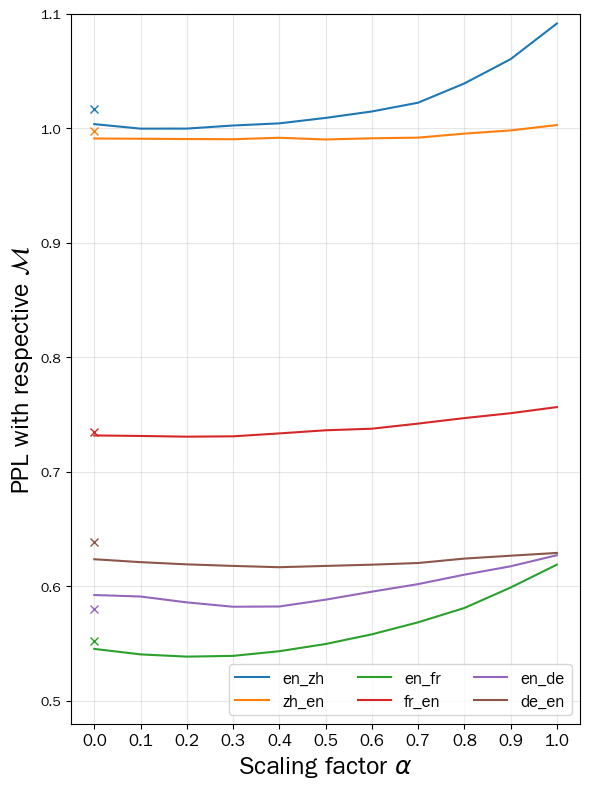

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ["WenQuanYi Zen Hei"]
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
colors = sns.color_palette(n_colors=6)

plt.figure(figsize=(6, 8))
plt.ylim(0.48, 1.1)
plt.xticks(np.arange(0, 1.1, 0.1), fontsize=12)
plt.xlabel(r"Scaling factor $\alpha$", fontsize=18)
plt.ylabel(r"PPL with respective $\mathcal{M}$", fontsize=18)
# plt.yticks(fontsize=12)
maskonly_ppl = {
    "en_fr": 0.551806, "en_de": 0.580341, "en_zh": 1.016755,
    "fr_en": 0.734948, "de_en": 0.638766, "zh_en": 0.997446
}
for i, (lang_pair, values) in enumerate(df.iterrows()):
    plt.plot(np.arange(0, 1.1, 0.1), values, linestyle='-', label=lang_pair, c=colors[i])
    plt.plot(0, maskonly_ppl[lang_pair], marker="x", c=colors[i])
plt.grid(alpha=0.3)
plt.legend(ncol=3, fontsize=12, loc="lower right")
plt.tight_layout()
plt.show()

evaluate on IWSLT2017 (Table 8)

In [ ]:
import datasets
import pandas as pd
import copy
import jieba
import re
import numpy as np
import itertools
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LANG_DICT = {"fr": "French", "de": "German", "en": "English", "zh": "Chinese"}
LANGPAIR_MIN = {"en_de": 0.3, "en_fr": 0.2, "en_zh": 0.1, "zh_en": 0.3, "fr_en": 0.2, "de_en": 0.4}

langs_original_bleu, langs_weighted_bleu = {}, {}
smoothing = SmoothingFunction().method1
# from OpenCompass
def general_postprocess(text: str) -> str:
    # Remove instructions
    answer_text = text.split("\n\n")
    if len(answer_text) > 2:
        answer_text = answer_text[1:2]
    elif len(answer_text) > 1:
        answer_text = answer_text[1:]
    answer_text = "\n\n".join(answer_text)
    # Cut off the first newline, period, or comma
    # truncated_text = re.split(r'[\n.,]', answer_text, 1)[0]
    # Remove punctuation
    no_punctuation = re.sub(r'[^\w\s]', '', answer_text)
    # Remove article
    # no_articles = re.sub(r'\b(a|an|the)\b',
    #                      '',
    #                      no_punctuation,
    #                      flags=re.IGNORECASE)
    # Remove duplicated blank spaces
    cleaned_text = re.sub(r'\s+', ' ', no_punctuation).strip()
    cleaned_text = " ".join(jieba.cut(cleaned_text))

    return cleaned_text

def postprocess_and_score(text: str, target_str: str):
    # Remove instructions
    answer_text = text.split("\n\n")
    cleaned_texts = [" ".join(jieba.cut(re.sub(r'\s+', ' ', re.sub(r'[^\w\s]', '', t)).strip())) for t in answer_text]
    scores = [sentence_bleu([target_str], t, smoothing_function=smoothing) for t in cleaned_texts]
    return max(zip(cleaned_texts, scores), key=lambda x: x[1])

for src_lang, tgt_lang in [("en", "de"), ("en", "fr"), ("de", "en"), ("fr", "en"), ("en", "zh"), ("zh", "en")]:
    if tgt_lang != "en":
        dev_dataset = datasets.Dataset.from_parquet(f"./dataset/iwslt2017/{src_lang}-{tgt_lang}-test.parquet")
    else:
        dev_dataset = datasets.Dataset.from_parquet(f"./dataset/iwslt2017/{tgt_lang}-{src_lang}-test.parquet")
    dev_dataset = dev_dataset.map(
        lambda sample: {
            "input_str": f"{sample['translation'][src_lang]}\n\nTranslate into {tgt_lang}:",
            "target_str": sample['translation'][tgt_lang],
        }
    ).select_columns(["input_str", "target_str"])

    mask_weight = (weight_dict[f"{src_lang}_{tgt_lang}"].sigmoid() >= 0.5).float().numpy().clip(min=LANGPAIR_MIN[f"{src_lang}_{tgt_lang}"])
    original_bleu, weighted_bleu = [], []
    for sample in tqdm(dev_dataset):
        input_str, target_str = sample["input_str"], sample["target_str"]
        target_str = general_postprocess(target_str)
        combined_str = LLAMA_TEMPLATE.format(src=input_str.strip())
        lm_inputs_src = tokenizer(
            combined_str, 
            max_length=2048, 
            truncation=True, 
            padding=False, 
            add_special_tokens=False,
            return_tensors="pt"
        ).to(DEVICE)

        with torch.no_grad():
            # w/o mask
            original_generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=None, do_sample=False)
            original_pred_str = tokenizer.decode(original_generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
            original_pred_str, original_bleu4 = postprocess_and_score(original_pred_str, target_str)
            original_bleu.append(original_bleu4)
            # w/ (scaled) mask
            mask_tensor = torch.tensor(mask_weight).unsqueeze(0).repeat(1, 1).to(model.device)
            weighted_generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=mask_tensor, do_sample=False)
            weighted_pred_str = tokenizer.decode(weighted_generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
            weighted_pred_str, weighted_bleu4 = postprocess_and_score(weighted_pred_str, target_str)
            weighted_bleu.append(weighted_bleu4)
            pass

    langs_original_bleu[f"{src_lang}_{tgt_lang}"] = np.nanmean(original_bleu)
    langs_weighted_bleu[f"{src_lang}_{tgt_lang}"] = np.nanmean(weighted_bleu)
    print(f"{src_lang}_{tgt_lang}: {np.nanmean(original_bleu)} {np.nanmean(weighted_bleu)}")
original_df = pd.DataFrame.from_dict(langs_original_bleu, orient="index")
display(original_df)
weighted_df = pd.DataFrame.from_dict(langs_weighted_bleu, orient="index")
display(weighted_df)